In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

1. Eczema 1677
2. Melanoma 15.75k
3. Atopic Dermatitis - 1.25k
4. Basal Cell Carcinoma (BCC) 3323
5. Melanocytic Nevi (NV) - 7970
6. Benign Keratosis-like Lesions (BKL) 2624
7. Psoriasis pictures Lichen Planus and related diseases - 2k
8. Seborrheic Keratoses and other Benign Tumors - 1.8k
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
10. Warts Molluscum and other Viral Infections - 2103
11. Oily-Dry-Skin-Types

In [2]:
train_dir = 'content/skin-data/train'
test_dir = 'content/skin-data/test'
val_dir = 'content/skin-data/val'

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)



In [4]:
from PIL import Image

image_path = 'content/skin-data/test/1/t-03DermatitisArm.jpg'
image = Image.open(image_path)
width, height = image.size

print(f"이미지 크기: {width}x{height}")

이미지 크기: 720x472


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # 이미지 크기 조정
    batch_size=16,
    class_mode='categorical'  # 다중 클래스 분류
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 20679 images belonging to 11 classes.
Found 4100 images belonging to 11 classes.
Found 3984 images belonging to 11 classes.


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model1 = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding="same"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
#     layers.MaxPooling2D((2, 2))
# ])
# base_model.trainable = False

# 모든 층의 가중치 동결 (trainable=False)
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(11, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 11)                5643      
                                                                 
Total params: 74974091 (286.00 MB)
Trainable params: 51386379 (196.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',    # 'val_loss'를 기준으로 모니터링
    patience=2,            # 성능이 개선되지 않는 에포크 수 (기다리는 횟수)
    verbose=1,             # 출력 메시지 (1: 켜기, 0: 끄기)
    restore_best_weights=True # 최적의 가중치를 복원
)

In [17]:
# # 모델 학습
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=5,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size
# )

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping] # EarlyStopping
)

# 모델
# 0.67 
# 0.69

# 사전모델
# 0.66
# 0.37

Epoch 1/5
1292/1292 [==============================] - 1783s 1s/step - loss: 1.4816 - accuracy: 0.4395 - val_loss: 1.5167 - val_accuracy: 0.4021
Epoch 2/5
1292/1292 [==============================] - 1722s 1s/step - loss: 1.4606 - accuracy: 0.4430 - val_loss: 1.4844 - val_accuracy: 0.4141
Epoch 3/5
1292/1292 [==============================] - 1644s 1s/step - loss: 1.4324 - accuracy: 0.4483 - val_loss: 1.4949 - val_accuracy: 0.4009
Epoch 4/5
1292/1292 [==============================] - 1655s 1s/step - loss: 1.4261 - accuracy: 0.4495 - val_loss: 1.4515 - val_accuracy: 0.4338
Epoch 5/5
1292/1292 [==============================] - 1667s 1s/step - loss: 1.4168 - accuracy: 0.4518 - val_loss: 1.7071 - val_accuracy: 0.3975


In [18]:
model.evaluate(test_generator)

249/249 [==============================] - 200s 802ms/step - loss: 1.7791 - accuracy: 0.3720


[1.7790716886520386, 0.3719879388809204]

In [11]:
history

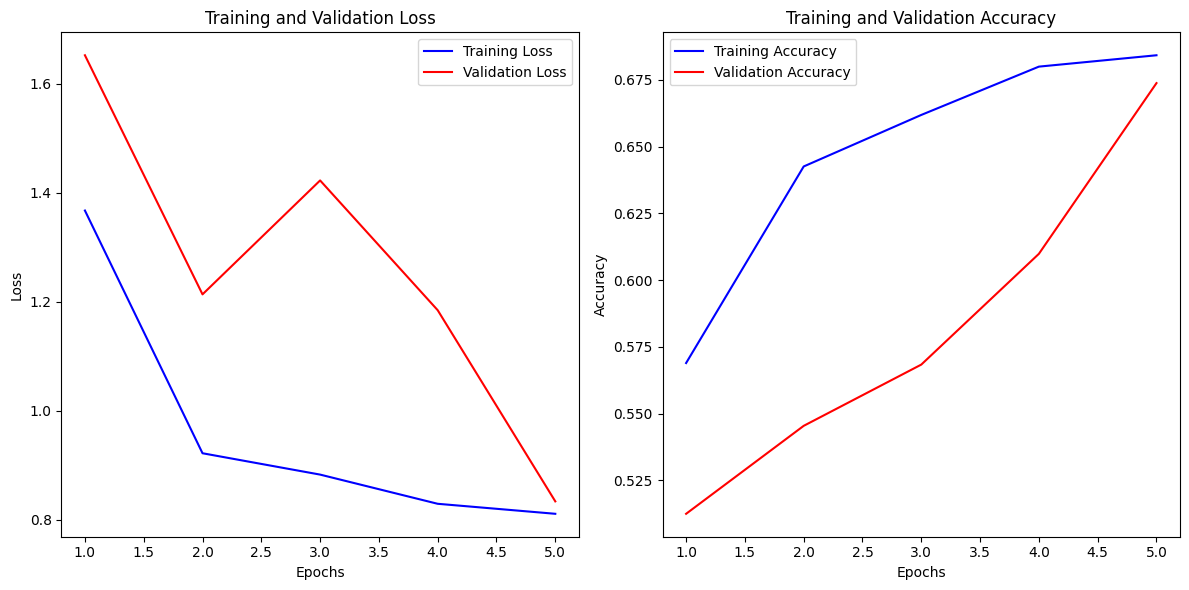

In [ ]:
import matplotlib.pyplot as plt

# 학습 기록에서 손실과 정확도 데이터를 가져옴
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', None)
val_accuracy = history.history.get('val_accuracy', None)

epochs = range(1, len(loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 (정확도가 있는 경우만)
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
